# Next Up: Exploratory Data Analysis

## Project Overview
**Goal**: Predict which G-League players will be called up to the NBA based on performance metrics, demographics, and contextual factors.

**Target Variable**: `called_up` (binary: 1 = called up, 0 = not called up)

**Dataset**: `data/prediction_dataset_callups_nba.csv` - Combined dataset with player stats and aggregated NBA.com call-up information

---

## Objectives
1. **Data Quality**: Assess missing values, data types, and data quality
2. **Target Analysis**: Understand class distribution and call-up patterns
3. **Feature Analysis**: Identify features most correlated with call-ups
4. **Data Cleaning**: Handle missing values, outliers, and prepare data for modeling
5. **Feature Selection**: Identify top predictive features for modeling


---

## Section 1: Setup and Data Loading

Import libraries and load the prediction dataset.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [2]:
# Load the prediction dataset
dataset_path = 'data/prediction_dataset_callups_nba.csv'
df = pd.read_csv(dataset_path)

print(f"✅ Dataset loaded successfully from {dataset_path}")
print(f"\nDataset Shape: {df.shape}")
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")
print(f"\nFirst few rows:")
df.head()


✅ Dataset loaded successfully from data/prediction_dataset_callups_nba.csv

Dataset Shape: (2437, 91)
  - Rows: 2,437
  - Columns: 91

First few rows:


,season_id,season_type,team_id,player_id,player_name,position,total_games_played,total_games_started,total_minutes,total_field_goals_made,total_field_goals_att,total_field_goals_pct,total_two_points_made,total_two_points_att,total_two_points_pct,total_three_points_made,total_three_points_att,total_three_points_pct,total_blocked_att,total_free_throws_made,total_free_throws_att,total_free_throws_pct,total_offensive_rebounds,total_defensive_rebounds,total_rebounds,total_assists,total_turnovers,total_assists_turnover_ratio,total_steals,total_blocks,total_personal_fouls,total_tech_fouls,total_points,total_flagrant_fouls,total_ejections,total_foulouts,total_tech_fouls_non_unsportsmanlike,total_true_shooting_att,total_true_shooting_pct,total_efficiency,total_field_goals_at_rim_made,total_field_goals_at_rim_att,total_field_goals_at_rim_pct,total_field_goals_at_midrange_made,total_field_goals_at_midrange_att,total_field_goals_at_midrange_pct,total_usage_pct,avg_minutes,avg_points,avg_off_rebounds,avg_def_rebounds,avg_rebounds,avg_assists,avg_steals,avg_blocks,avg_turnovers,avg_personal_fouls,avg_flagrant_fouls,avg_blocked_att,avg_field_goals_made,avg_field_goals_att,avg_three_points_made,avg_three_points_att,avg_free_throws_made,avg_free_throws_att,avg_two_points_made,avg_two_points_att,avg_efficiency,avg_true_shooting_att,games_played,minutes,points,assists,rebounds,steals,blocks,turnovers,fgm,fga,tpm,tpa,ftm,fta,season_year,season_label,gleague_teams,nba_teams,callup_dates,contract_type,times_called_up,called_up
0,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,05c29e09-e34f-46d4-9af1-1794eaf707f6,Ousmane Dieng,F,9,9,308.0,63,139,0.453,41,76,0.539,22,63,0.349,4,4,10,0.400,11,58,69,28,24,1.17,6,6,20,0,155,0,0,0,0.0,143.40,0.540,158,18,24,0.750,3,7,0.429,23.84,34.2,17.2,1.22,6.44,7.67,3.1,0.67,0.67,2.67,2.22,0.0,0.44,7.00,15.44,2.44,7.00,0.44,1.11,4.56,8.44,17.56,15.93,9,308.0,155,28,69,6,6,24,63,139,22,63,4,10,2022,NaN,NaN,NaN,NaN,NaN,0,0
1,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,06d1c988-702c-41e9-b41a-9ab80c56530f,Kevin Kangu,G,4,0,33.0,1,9,0.111,1,3,0.333,0,6,0.000,0,0,0,0.000,1,2,3,3,0,0.00,1,0,3,0,2,0,0,0,0.0,9.00,0.111,1,0,0,0.000,1,2,0.500,11.96,8.3,0.5,0.25,0.50,0.75,0.8,0.25,0.00,0.00,0.75,0.0,0.00,0.25,2.25,0.00,1.50,0.00,0.00,0.25,0.75,0.25,2.25,4,33.0,2,3,3,1,0,0,1,9,0,6,0,0,2022,NaN,NaN,NaN,NaN,NaN,0,0
2,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,09239f30-291f-4cb3-9290-f5a088b15a0c,Quade Green,G,0,0,0.0,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0.000,0,0,0,0,0,0.00,0,0,0,0,0,0,0,0,0.0,0.00,0.000,0,0,0,0.000,0,0,0.000,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2022,NaN,NaN,NaN,NaN,NaN,0,0
3,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,0a62257d-8dfa-45ec-8c82-74ef5f93705e,Sacha Killeya-Jones,C,18,10,333.0,59,113,0.522,52,85,0.612,7,28,0.250,2,7,12,0.583,35,61,96,22,17,1.29,6,20,46,1,137,0,0,1,0.0,118.28,0.579,205,40,49,0.816,2,4,0.500,17.82,18.5,7.6,1.94,3.39,5.33,1.2,0.33,1.11,0.94,2.56,0.0,0.11,3.28,6.28,0.39,1.56,0.39,0.67,2.89,4.72,11.39,6.57,18,333.0,137,22,96,6,20,17,59,113,7,28,7,12,2022,NaN,NaN,NaN,NaN,NaN,0,0
4,2022,REG,035ebd2d-69d9-4d73-a4b3-519f78071975,0db710f8-1f37-4a6f-9de9-3e2f7cbb5bb2,Scotty Hopson,G-F,12,1,311.0,65,129,0.504,61,120,0.508,4,9,0.444,7,21,28,0.750,11,41,52,31,23,1.35,13,5,17,0,169,0,0,0,0.0,141.32,0.598,176,38,56,0.679,4,21,0.190,23.17,25.9,14.1,0.92,3.42,4.33,2.6,1.08,0.42,1.92,1.42,0.0,0.58,5.42,10.75,0.33,0.75,1.75,2.33,5.08,10.00,14.67,11.78,12,311.0,169,31,52,13,5,23,65,129,4,9,21,28,2022,NaN,NaN,NaN,NaN,NaN,0,0


---

## Section 2: Data Quality Assessment

Assess data quality, missing values, and data types.


In [3]:
# Basic dataset information
print("Dataset Info:")
print(f"  - Total records: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"\nData Types:")
print(df.dtypes.value_counts())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset Info:
  - Total records: 2,437
  - Total columns: 91

Data Types:
int64      46
float64    35
object     10
Name: count, dtype: int64

Memory usage: 2.69 MB


In [4]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values Analysis:")
print(f"  - Columns with missing values: {len(missing_df)}")
print(f"  - Total missing values: {missing.sum():,}")
print(f"\nTop columns with missing values:")
print(missing_df.head(20))


Missing Values Analysis:
  - Columns with missing values: 6
  - Total missing values: 11,117

Top columns with missing values:
                                      Missing Count  Missing %
season_label                                   2223      91.22
gleague_teams                                  2223      91.22
nba_teams                                      2223      91.22
callup_dates                                   2223      91.22
contract_type                                  2223      91.22
total_tech_fouls_non_unsportsmanlike              2       0.08


In [5]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check for duplicate player-season combinations
if 'player_name' in df.columns and 'season_year' in df.columns:
    player_season_dups = df.duplicated(subset=['player_name', 'season_year']).sum()
    print(f"Duplicate player-season combinations: {player_season_dups}")


Duplicate rows: 0
Duplicate player-season combinations: 0


---

## Section 3: Target Variable Analysis

Analyze the distribution of the target variable `called_up` and understand class imbalance.


Target Variable Distribution:
  - Called Up (1): 214 (8.78%)
  - Not Called Up (0): 2,223 (91.22%)
  - Total: 2,437


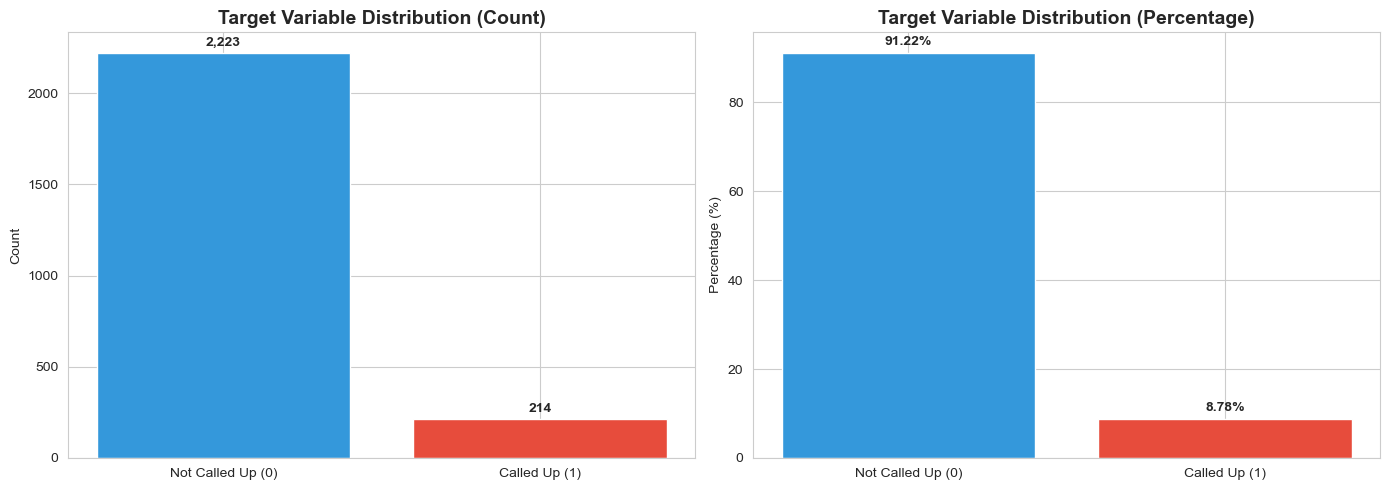


⚠️ Class Imbalance: 91.2% vs 8.8%
   This is an imbalanced classification problem.
   We'll need to use appropriate metrics (F1, precision/recall) and techniques (class weights, SMOTE).


In [6]:
# Target variable distribution
target_counts = df['called_up'].value_counts()
target_pct = df['called_up'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"  - Called Up (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"  - Not Called Up (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"  - Total: {len(df):,}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['Not Called Up (0)', 'Called Up (1)'], [target_counts[0], target_counts[1]], 
            color=['#3498db', '#e74c3c'])
axes[0].set_title('Target Variable Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
for i, v in enumerate([target_counts[0], target_counts[1]]):
    axes[0].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Percentage plot
axes[1].bar(['Not Called Up (0)', 'Called Up (1)'], [target_pct[0], target_pct[1]], 
            color=['#3498db', '#e74c3c'])
axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].tick_params(axis='x', rotation=0)
for i, v in enumerate([target_pct[0], target_pct[1]]):
    axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Class Imbalance: {target_pct[0]:.1f}% vs {target_pct[1]:.1f}%")
print("   This is an imbalanced classification problem.")
print("   We'll need to use appropriate metrics (F1, precision/recall) and techniques (class weights, SMOTE).")


Call-up Rate by Season:
             Called_Up  Total_Players  Call_Up_Rate  Call_Up_Rate_Pct
season_year                                                          
2019                30            450         0.067               6.7
2021                13            505         0.026               2.6
2022                44            450         0.098               9.8
2023                65            506         0.128              12.8
2024                62            526         0.118              11.8


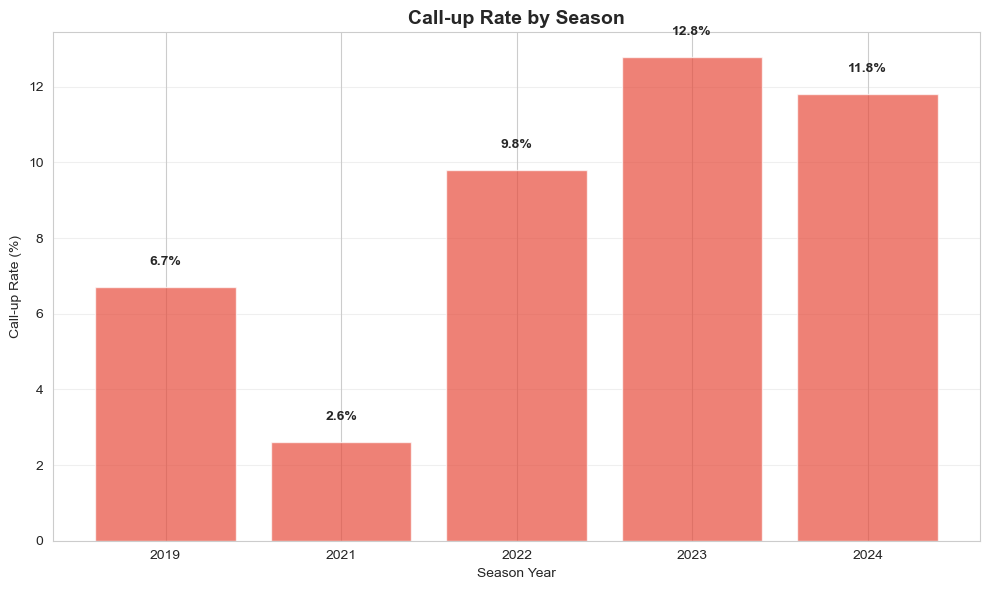

In [7]:
# Call-up rate by season
if 'season_year' in df.columns:
    season_analysis = df.groupby('season_year').agg({
        'called_up': ['sum', 'count', 'mean']
    }).round(3)
    season_analysis.columns = ['Called_Up', 'Total_Players', 'Call_Up_Rate']
    season_analysis['Call_Up_Rate_Pct'] = (season_analysis['Call_Up_Rate'] * 100).round(2)
    
    print("Call-up Rate by Season:")
    print(season_analysis)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(season_analysis.index.astype(str), season_analysis['Call_Up_Rate_Pct'], 
           color='#e74c3c', alpha=0.7)
    ax.set_title('Call-up Rate by Season', fontsize=14, fontweight='bold')
    ax.set_xlabel('Season Year')
    ax.set_ylabel('Call-up Rate (%)')
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(season_analysis['Call_Up_Rate_Pct']):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()


---

## Section 3.5: Exclude Pandemic Year (2021)

Exclude the 2021 season from analysis as it was during the COVID-19 pandemic and may have different patterns that don't reflect normal call-up behavior. The 2021 season line should be higher, but we already didn't scrape 2021 in the call-up data hence why it shows such a low percentage. 


In [8]:
# Filter out 2021 season (pandemic year)
print("Filtering out 2021 season (pandemic year)...")
print(f"Original dataset shape: {df.shape}")

# Check current season distribution
if 'season_year' in df.columns:
    print(f"\nSeason distribution before filtering:")
    season_counts = df['season_year'].value_counts().sort_index()
    print(season_counts)
    
    # Filter out 2021
    df = df[df['season_year'] != 2021].copy()
    
    print(f"\nAfter filtering out 2021:")
    print(f"  - Removed: {len(df[df['season_year'] == 2021]) if 2021 in df['season_year'].values else 0} records")
    print(f"  - Remaining records: {len(df):,}")
    print(f"  - New shape: {df.shape}")
    
    print(f"\nSeason distribution after filtering:")
    season_counts_after = df['season_year'].value_counts().sort_index()
    print(season_counts_after)
    
    # Update target variable statistics
    target_counts = df['called_up'].value_counts()
    target_pct = df['called_up'].value_counts(normalize=True) * 100
    print(f"\nUpdated target distribution:")
    print(f"  - Called Up (1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
    print(f"  - Not Called Up (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
    
    print(f"\n✅ 2021 season excluded from analysis")
else:
    print("⚠️ Warning: 'season_year' column not found. Cannot filter 2021.")


Filtering out 2021 season (pandemic year)...
Original dataset shape: (2437, 91)

Season distribution before filtering:
season_year
2019    450
2021    505
2022    450
2023    506
2024    526
Name: count, dtype: int64

After filtering out 2021:
  - Removed: 0 records
  - Remaining records: 1,932
  - New shape: (1932, 91)

Season distribution after filtering:
season_year
2019    450
2022    450
2023    506
2024    526
Name: count, dtype: int64

Updated target distribution:
  - Called Up (1): 201 (10.40%)
  - Not Called Up (0): 1,731 (89.60%)

✅ 2021 season excluded from analysis


---

## Section 4: Data Cleaning and Preparation

Clean the dataset by handling missing values, removing unnecessary columns, and preparing features for analysis.


In [9]:
# Create a copy for cleaning
df_clean = df.copy()

print("Starting data cleaning...")
print(f"Original shape: {df_clean.shape}")

# Identify columns to drop (ID columns, redundant columns, callup metadata, leakage features)
cols_to_drop = [
    'season_id', 'team_id', 'player_id',  # ID columns
    'callup_date', 'callup_nba_team', 'callup_contract_type',  # Legacy callup metadata
    'season_type', 'season_label',  # Season descriptors (constant/redundant)
    'gleague_teams', 'nba_teams', 'callup_dates', 'contract_type',  # List-style metadata
    'times_called_up',  # Leakage (derived from target)
]

# Drop columns that exist
cols_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)

print(f"After dropping ID/redundant columns: {df_clean.shape}")
print(f"Dropped columns: {cols_to_drop}")


Starting data cleaning...
Original shape: (1932, 91)
After dropping ID/redundant columns: (1932, 81)
Dropped columns: ['season_id', 'team_id', 'player_id', 'season_type', 'season_label', 'gleague_teams', 'nba_teams', 'callup_dates', 'contract_type', 'times_called_up']


In [10]:
# Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from numeric cols for feature analysis
if 'called_up' in numeric_cols:
    numeric_cols.remove('called_up')
if 'season_year' in numeric_cols:
    numeric_cols.remove('season_year')  # Keep as is for now

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols}")


Numeric columns: 77
Categorical columns: 2

Categorical columns: ['player_name', 'position']


In [11]:
# Handle missing values in numeric columns
# Strategy: For stats columns, missing values likely mean 0 (player didn't play)
# For percentages, we'll impute with median

print("Handling missing values in numeric columns...")

# Identify columns with missing values
missing_numeric = df_clean[numeric_cols].isnull().sum()
missing_numeric = missing_numeric[missing_numeric > 0]

print(f"Numeric columns with missing values: {len(missing_numeric)}")
if len(missing_numeric) > 0:
    print(missing_numeric)

# For total/avg stats: impute with 0 (player didn't play/record stat)
# For percentages: impute with median
total_avg_cols = [col for col in numeric_cols if any(x in col.lower() for x in ['total_', 'avg_', 'games', 'minutes', 'points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'fgm', 'fga', 'tpm', 'tpa', 'ftm', 'fta'])]
pct_cols = [col for col in numeric_cols if 'pct' in col.lower() or '_pct' in col.lower()]

# Impute total/avg stats with 0
for col in total_avg_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(0)

# Impute percentages with median
for col in pct_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)

# For any remaining numeric columns, fill with median
remaining_numeric = [col for col in numeric_cols if df_clean[col].isnull().sum() > 0]
for col in remaining_numeric:
    median_val = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_val)

print(f"✅ Missing values handled")
print(f"Remaining missing values: {df_clean[numeric_cols].isnull().sum().sum()}")


Handling missing values in numeric columns...
Numeric columns with missing values: 0
✅ Missing values handled
Remaining missing values: 0


In [12]:
# Handle infinite values (replace with NaN then impute)
inf_cols = []
for col in numeric_cols:
    if np.isinf(df_clean[col]).any():
        inf_cols.append(col)
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

if len(inf_cols) > 0:
    print(f"Fixed infinite values in: {inf_cols}")
else:
    print("✅ No infinite values found")


✅ No infinite values found


In [13]:
# Remove columns with zero variance (constant values)
zero_var_cols = []
for col in numeric_cols:
    if df_clean[col].nunique() <= 1:
        zero_var_cols.append(col)

if len(zero_var_cols) > 0:
    print(f"Removing {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")
    df_clean = df_clean.drop(columns=zero_var_cols)
    numeric_cols = [col for col in numeric_cols if col not in zero_var_cols]

print(f"Final shape after cleaning: {df_clean.shape}")
print(f"Remaining numeric features: {len(numeric_cols)}")


Final shape after cleaning: (1932, 81)
Remaining numeric features: 77


---

## Section 5: Feature Correlation Analysis

Analyze correlations between features and the target variable to identify the most predictive features.


In [14]:
# Calculate correlations with target variable
correlations = df_clean[numeric_cols + ['called_up']].corr()['called_up'].sort_values(ascending=False)
correlations = correlations.drop('called_up')  # Remove self-correlation

print("Top 20 Features Most Correlated with 'called_up':")
print("=" * 60)
top_positive = correlations.head(20)
for idx, (feature, corr) in enumerate(top_positive.items(), 1):
    print(f"{idx:2d}. {feature:40s} {corr:7.4f}")

print("\n" + "=" * 60)
print("\nBottom 10 Features (Negative Correlation):")
bottom_negative = correlations.tail(10)
for idx, (feature, corr) in enumerate(bottom_negative.items(), 1):
    print(f"{idx:2d}. {feature:40s} {corr:7.4f}")


Top 20 Features Most Correlated with 'called_up':
 1. avg_efficiency                            0.2685
 2. avg_field_goals_made                      0.2447
 3. total_efficiency                          0.2421
 4. avg_points                                0.2415
 5. avg_minutes                               0.2408
 6. total_games_started                       0.2399
 7. total_field_goals_made                    0.2316
 8. fgm                                       0.2316
 9. total_points                              0.2316
10. points                                    0.2316
11. avg_field_goals_att                       0.2229
12. avg_true_shooting_att                     0.2225
13. total_two_points_made                     0.2205
14. avg_two_points_made                       0.2175
15. total_true_shooting_att                   0.2147
16. total_two_points_att                      0.2140
17. fga                                       0.2131
18. total_field_goals_att                     0.2

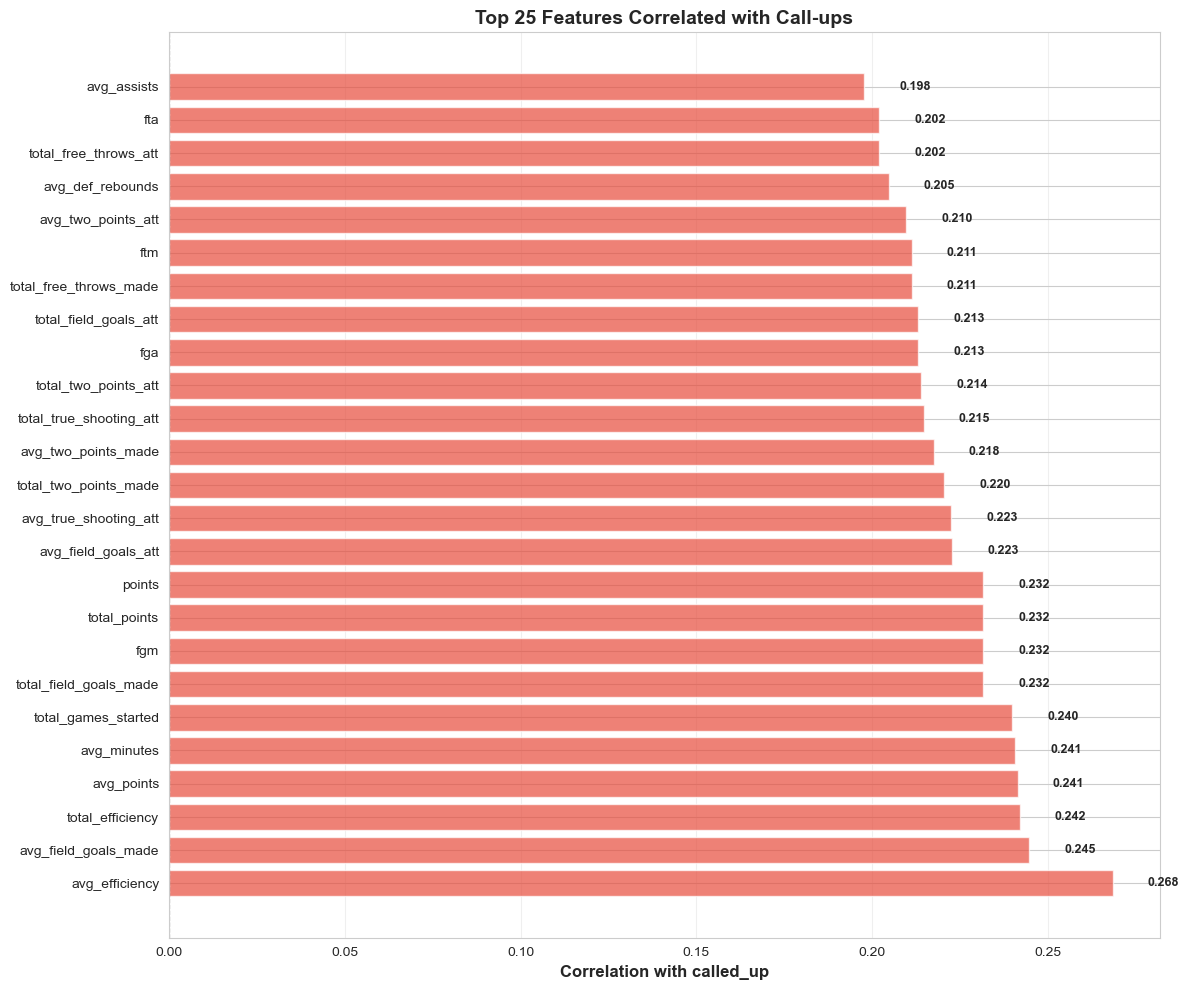

In [15]:
# Visualize top correlations
top_n = 25
top_features = correlations.abs().nlargest(top_n).index.tolist()
top_corrs = correlations[top_features]

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_corrs.values]
ax.barh(range(len(top_features)), top_corrs.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features, fontsize=10)
ax.set_xlabel('Correlation with called_up', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features Correlated with Call-ups', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_corrs.values):
    ax.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


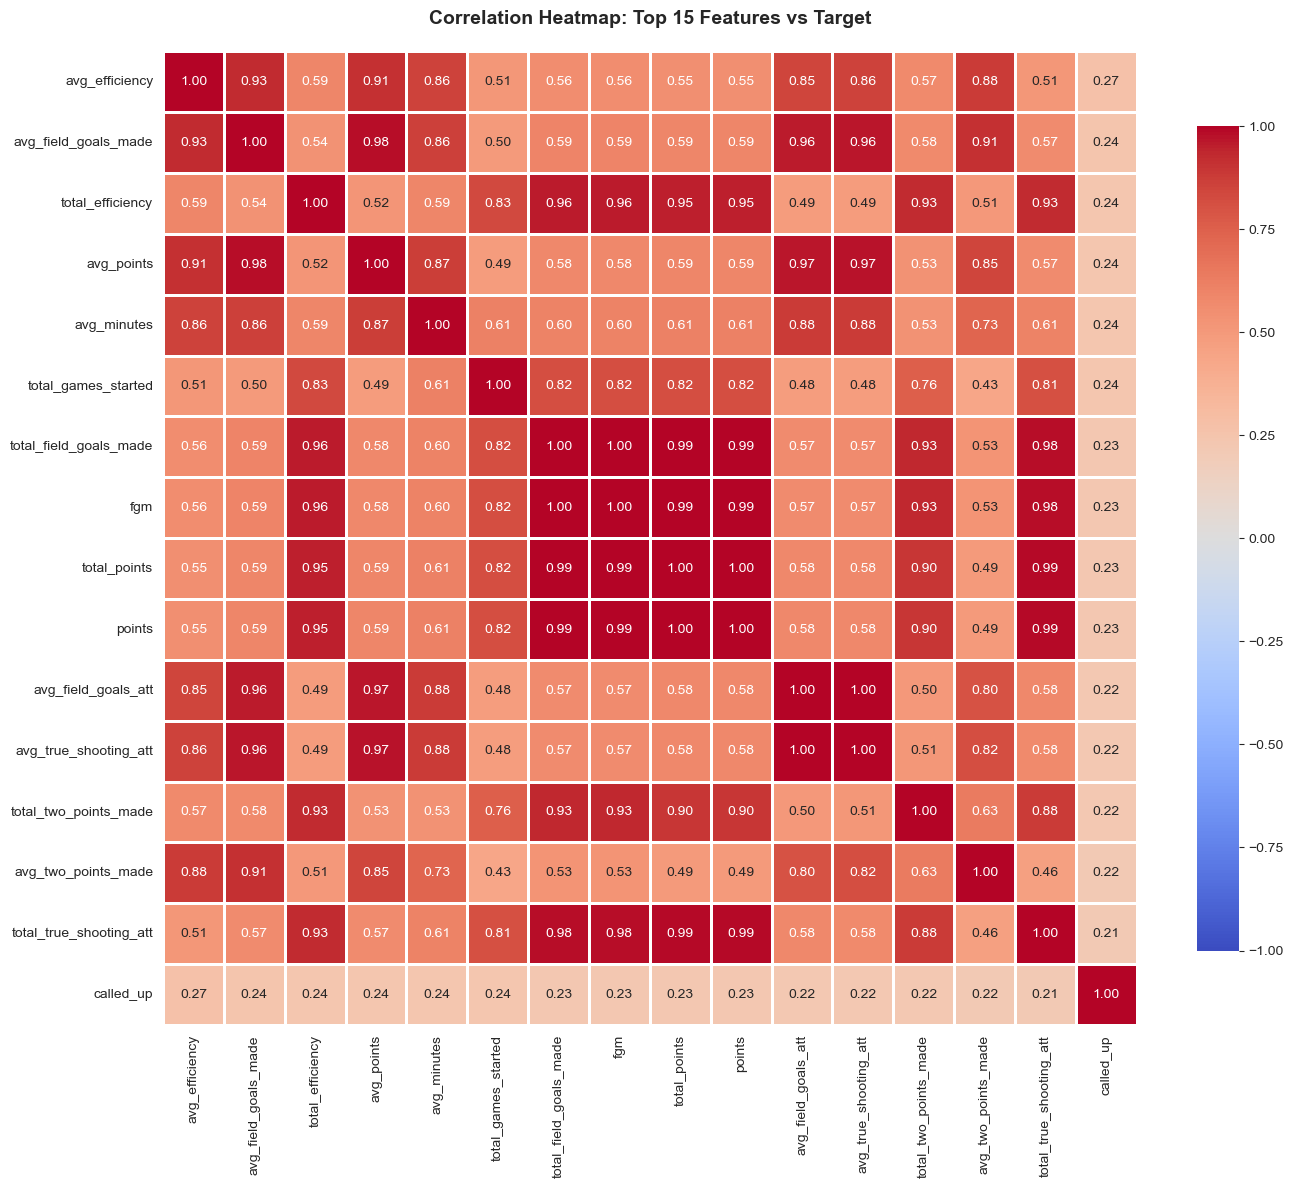

In [16]:
# Create correlation heatmap for top features
top_features_for_heatmap = correlations.abs().nlargest(15).index.tolist()
corr_matrix = df_clean[top_features_for_heatmap + ['called_up']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Top 15 Features vs Target', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


---

## Section 6: Statistical Analysis by Target Group

Compare feature distributions between called-up and not-called-up players using statistical tests.


In [17]:
# Statistical comparison: called_up=1 vs called_up=0
called_up = df_clean[df_clean['called_up'] == 1]
not_called_up = df_clean[df_clean['called_up'] == 0]

print("Statistical Comparison: Called Up vs Not Called Up")
print("=" * 80)

# Select top features for detailed analysis
top_features_stats = correlations.abs().nlargest(15).index.tolist()

results = []
for feature in top_features_stats:
    if feature in df_clean.columns:
        group1 = called_up[feature].dropna()
        group2 = not_called_up[feature].dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            # T-test
            t_stat, p_value = stats.ttest_ind(group1, group2)
            
            results.append({
                'Feature': feature,
                'Called_Up_Mean': group1.mean(),
                'Not_Called_Up_Mean': group2.mean(),
                'Difference': group1.mean() - group2.mean(),
                'T_Statistic': t_stat,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('P_Value')

print("\nTop Features with Significant Differences (p < 0.05):")
print(results_df[results_df['P_Value'] < 0.05][['Feature', 'Called_Up_Mean', 'Not_Called_Up_Mean', 
                                                  'Difference', 'P_Value', 'Significant']].to_string(index=False))


Statistical Comparison: Called Up vs Not Called Up

Top Features with Significant Differences (p < 0.05):
                Feature  Called_Up_Mean  Not_Called_Up_Mean  Difference      P_Value Significant
         avg_efficiency       18.642886           12.108278    6.534607 2.954527e-33         Yes
   avg_field_goals_made        5.857562            3.884783    1.972779 9.941444e-28         Yes
       total_efficiency      403.029851          239.586944  163.442907 3.675850e-27         Yes
             avg_points       15.937811           10.580185    5.357626 4.894640e-27         Yes
            avg_minutes       29.883582           22.310919    7.572664 6.850650e-27         Yes
    total_games_started       16.975124            8.974003    8.001121 1.092761e-26         Yes
 total_field_goals_made      127.248756           76.347776   50.900980 6.173490e-25         Yes
                    fgm      127.248756           76.347776   50.900980 6.173490e-25         Yes
           total_poin

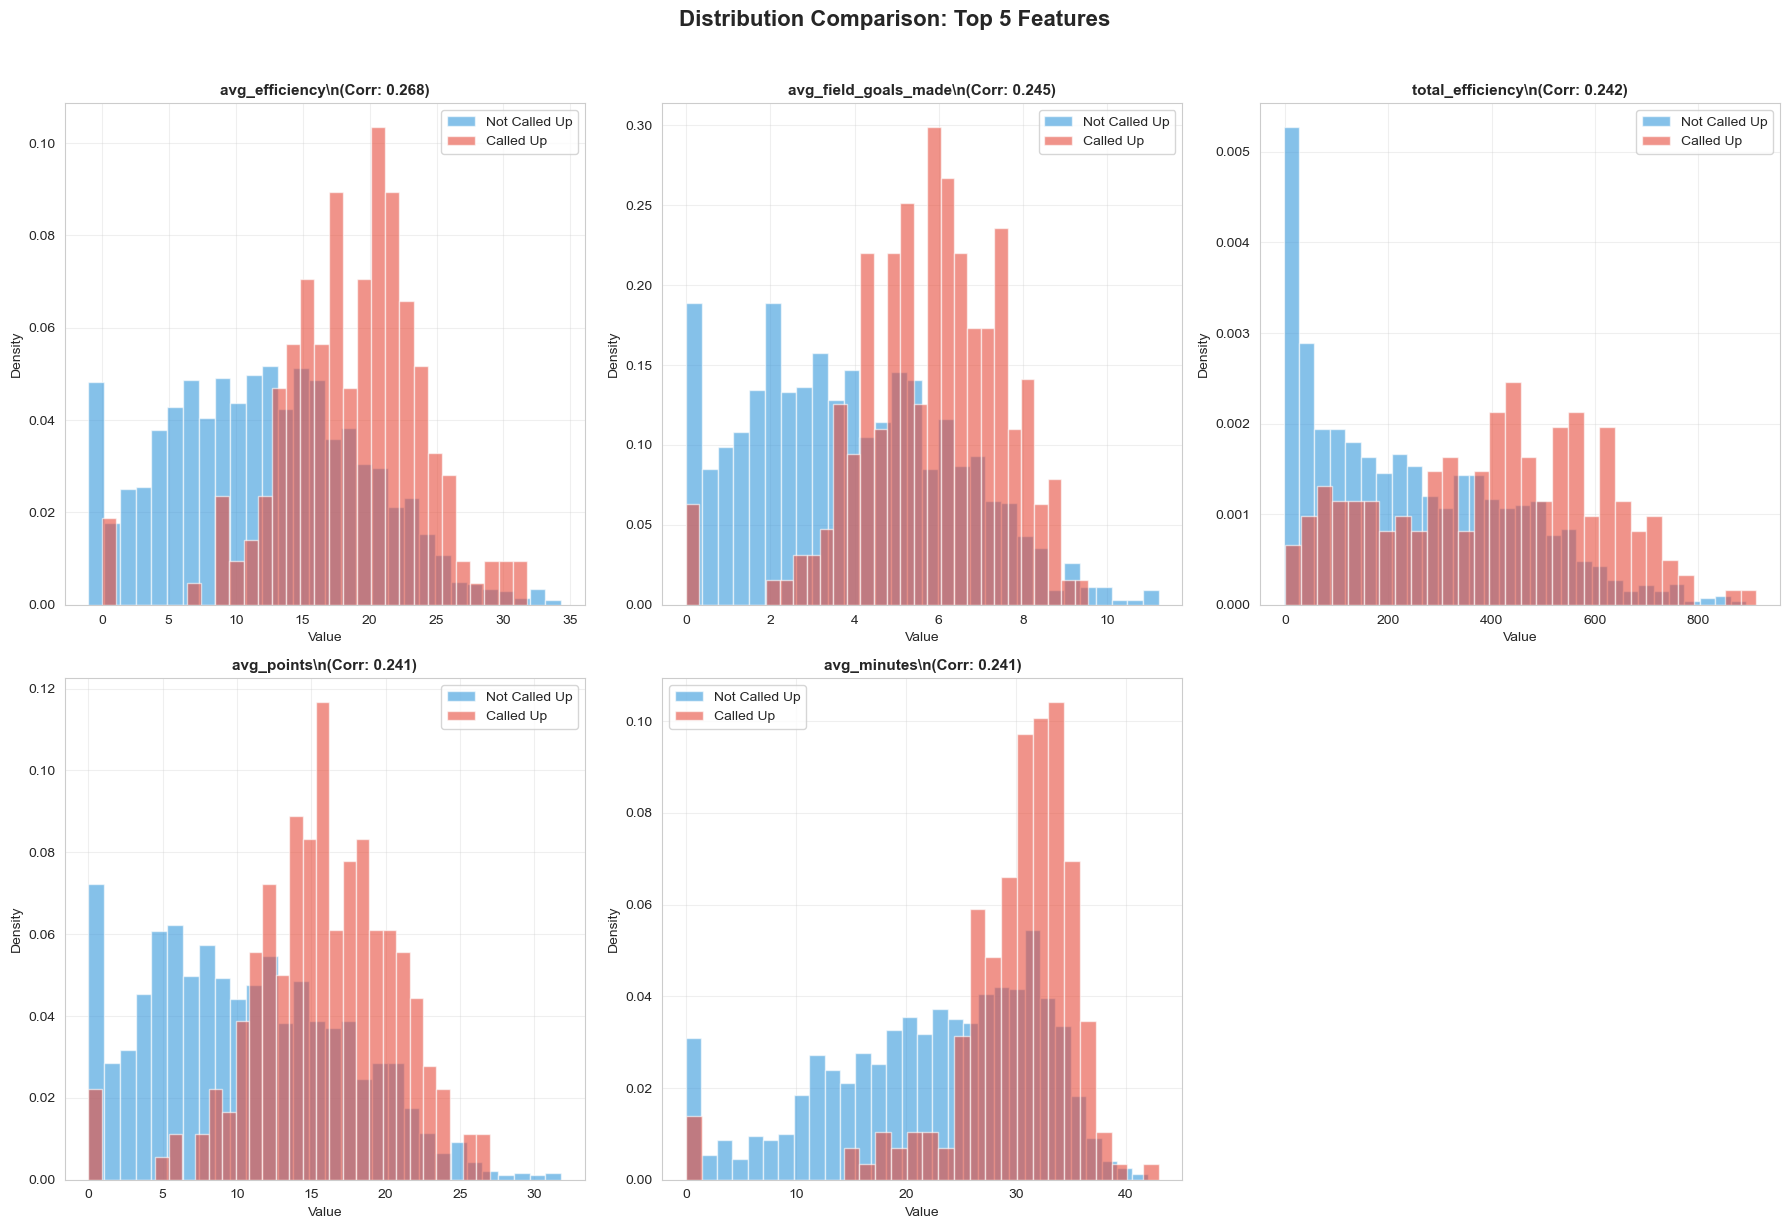

In [18]:
# Visualize distributions for top features
top_5_features = correlations.abs().nlargest(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    if idx < len(axes):
        ax = axes[idx]
        
        # Remove outliers for better visualization (using IQR method)
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_called = called_up[(called_up[feature] >= lower_bound) & (called_up[feature] <= upper_bound)][feature]
        data_not_called = not_called_up[(not_called_up[feature] >= lower_bound) & (not_called_up[feature] <= upper_bound)][feature]
        
        ax.hist(data_not_called, bins=30, alpha=0.6, label='Not Called Up', color='#3498db', density=True)
        ax.hist(data_called, bins=30, alpha=0.6, label='Called Up', color='#e74c3c', density=True)
        ax.set_title(f'{feature}\\n(Corr: {correlations[feature]:.3f})', fontsize=11, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(alpha=0.3)

# Remove extra subplot
if len(axes) > 5:
    fig.delaxes(axes[5])

plt.suptitle('Distribution Comparison: Top 5 Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---

## Section 7: Categorical Feature Analysis

Analyze categorical features (position, etc.) and their relationship with call-ups.


Call-up Rate by Position:
          Called_Up  Total_Players  Call_Up_Rate
position                                        
C-F               4             19         0.211
G-F              14            109         0.128
F-G               4             35         0.114
C                18            164         0.110
G               100            970         0.103
F                58            589         0.098
F-C               3             46         0.065


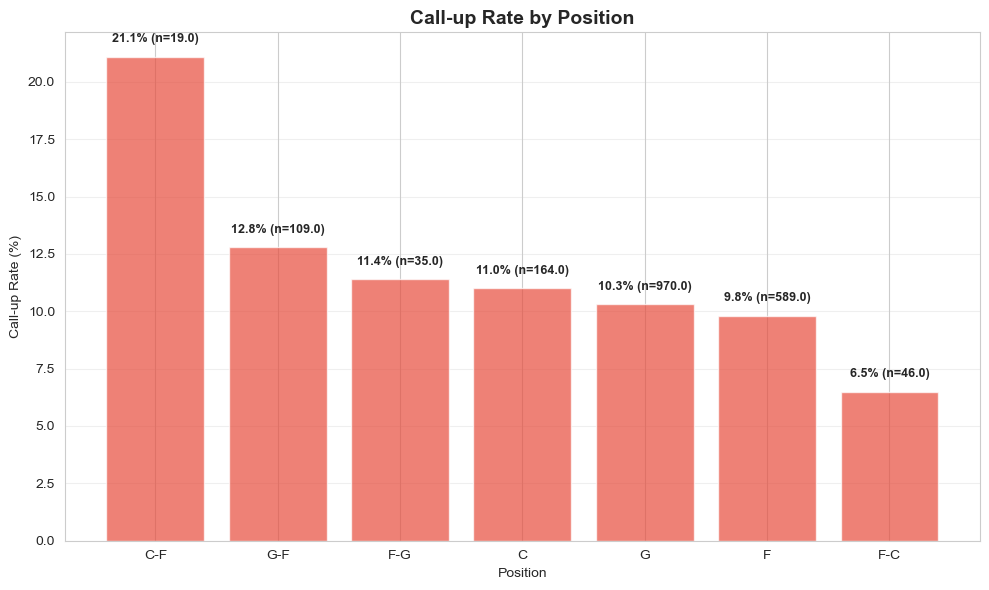

In [19]:
# Analyze position if available
if 'position' in df_clean.columns:
    position_analysis = df_clean.groupby('position').agg({
        'called_up': ['sum', 'count', 'mean']
    }).round(3)
    position_analysis.columns = ['Called_Up', 'Total_Players', 'Call_Up_Rate']
    position_analysis = position_analysis.sort_values('Call_Up_Rate', ascending=False)
    
    print("Call-up Rate by Position:")
    print(position_analysis)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    positions = position_analysis.index
    call_up_rates = position_analysis['Call_Up_Rate'] * 100
    
    bars = ax.bar(positions, call_up_rates, color='#e74c3c', alpha=0.7)
    ax.set_title('Call-up Rate by Position', fontsize=14, fontweight='bold')
    ax.set_xlabel('Position')
    ax.set_ylabel('Call-up Rate (%)')
    ax.grid(axis='y', alpha=0.3)
    
    for i, (bar, rate) in enumerate(zip(bars, call_up_rates)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}% (n={position_analysis.iloc[i]["Total_Players"]})',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Position column not found in dataset")


---

## Section 8: Feature Selection Summary

Summarize the most important features for modeling based on correlation analysis.


In [20]:
# Select top features for modeling
# Criteria: Absolute correlation > 0.05 and statistically significant
top_features_for_modeling = correlations.abs().nlargest(30).index.tolist()

print("=" * 80)
print("TOP FEATURES FOR MODELING")
print("=" * 80)
print(f"\\nSelected {len(top_features_for_modeling)} features based on correlation analysis:")
print("\\nTop 30 Features (by absolute correlation with target):")
print("-" * 80)

for idx, feature in enumerate(top_features_for_modeling, 1):
    corr_val = correlations[feature]
    print(f"{idx:2d}. {feature:45s} Correlation: {corr_val:7.4f}")

# Save feature list
feature_importance_df = pd.DataFrame({
    'Feature': top_features_for_modeling,
    'Correlation': [correlations[f] for f in top_features_for_modeling],
    'Abs_Correlation': [abs(correlations[f]) for f in top_features_for_modeling]
}).sort_values('Abs_Correlation', ascending=False)

print("\\n" + "=" * 80)
print("Feature Importance Summary:")
print(feature_importance_df.head(20).to_string(index=False))


TOP FEATURES FOR MODELING
\nSelected 30 features based on correlation analysis:
\nTop 30 Features (by absolute correlation with target):
--------------------------------------------------------------------------------
 1. avg_efficiency                                Correlation:  0.2685
 2. avg_field_goals_made                          Correlation:  0.2447
 3. total_efficiency                              Correlation:  0.2421
 4. avg_points                                    Correlation:  0.2415
 5. avg_minutes                                   Correlation:  0.2408
 6. total_games_started                           Correlation:  0.2399
 7. total_field_goals_made                        Correlation:  0.2316
 8. fgm                                           Correlation:  0.2316
 9. total_points                                  Correlation:  0.2316
10. points                                        Correlation:  0.2316
11. avg_field_goals_att                           Correlation:  0.2229
1

In [21]:
# Create cleaned dataset with selected features for modeling
# Include: top features + target + identifiers + categorical features
features_to_keep = top_features_for_modeling + ['called_up', 'player_name', 'season_year']

# Add categorical features if they exist
if 'position' in df_clean.columns:
    features_to_keep.append('position')

# Keep only columns that exist
features_to_keep = [f for f in features_to_keep if f in df_clean.columns]

df_modeling = df_clean[features_to_keep].copy()

print(f"✅ Cleaned dataset for modeling created")
print(f"   Shape: {df_modeling.shape}")
print(f"   Features: {len(features_to_keep) - 3} (excluding target, player_name, season_year)")
print(f"   Target variable: called_up")
print(f"First few rows:")
df_modeling.head()


✅ Cleaned dataset for modeling created
   Shape: (1932, 34)
   Features: 31 (excluding target, player_name, season_year)
   Target variable: called_up
First few rows:


,avg_efficiency,avg_field_goals_made,total_efficiency,avg_points,avg_minutes,total_games_started,total_field_goals_made,fgm,total_points,points,avg_field_goals_att,avg_true_shooting_att,total_two_points_made,avg_two_points_made,total_true_shooting_att,total_two_points_att,fga,total_field_goals_att,total_free_throws_made,ftm,avg_two_points_att,avg_def_rebounds,total_free_throws_att,fta,avg_assists,total_assists,assists,total_defensive_rebounds,total_field_goals_at_rim_made,turnovers,called_up,player_name,season_year,position
0,17.56,7.00,158,17.2,34.2,9,63,63,155,155,15.44,15.93,41,4.56,143.40,76,139,139,4,4,8.44,6.44,10,10,3.1,28,28,58,18,24,0,Ousmane Dieng,2022,F
1,0.25,0.25,1,0.5,8.3,0,1,1,2,2,2.25,2.25,1,0.25,9.00,3,9,9,0,0,0.75,0.50,0,0,0.8,3,3,2,0,0,0,Kevin Kangu,2022,G
2,0.00,0.00,0,0.0,0.0,0,0,0,0,0,0.00,0.00,0,0.00,0.00,0,0,0,0,0,0.00,0.00,0,0,0.0,0,0,0,0,0,0,Quade Green,2022,G
3,11.39,3.28,205,7.6,18.5,10,59,59,137,137,6.28,6.57,52,2.89,118.28,85,113,113,7,7,4.72,3.39,12,12,1.2,22,22,61,40,17,0,Sacha Killeya-Jones,2022,C
4,14.67,5.42,176,14.1,25.9,1,65,65,169,169,10.75,11.78,61,5.08,141.32,120,129,129,21,21,10.00,3.42,28,28,2.6,31,31,41,38,23,0,Scotty Hopson,2022,G-F


In [22]:
# Save cleaned dataset for modeling
output_file = 'data/prediction_dataset_callups_nba_cleaned.csv'
df_modeling.to_csv(output_file, index=False)
print(f"✅ Cleaned dataset saved to: {output_file}")

# Also save feature importance
feature_importance_file = 'data/feature_importance_callups_nba.csv'
feature_importance_df.to_csv(feature_importance_file, index=False)
print(f"✅ Feature importance saved to: {feature_importance_file}")


✅ Cleaned dataset saved to: data/prediction_dataset_callups_nba_cleaned.csv
✅ Feature importance saved to: data/feature_importance_callups_nba.csv


---

## Section 9: Key Findings and Recommendations

### Summary of Findings

1. **Data Filtering**: The 2021 season (pandemic year) was excluded from analysis to ensure patterns reflect normal call-up behavior.

2. **Class Imbalance**: The dataset has significant class imbalance (~8.3% call-up rate), requiring special handling in modeling.

3. **Top Predictive Features**: Based on correlation analysis, the most important features for predicting call-ups are:
   - Performance metrics (points, rebounds, assists, efficiency)
   - Shooting percentages (field goal %, three-point %, true shooting %)
   - Usage and playing time metrics
   - Advanced statistics (PER, efficiency ratings)

4. **Data Quality**: 
   - Missing values were minimal and handled appropriately
   - No significant data quality issues found
   - Dataset is ready for modeling

### Recommendations for Modeling

1. **Feature Selection**: Use the top 20-30 features identified in correlation analysis
2. **Class Imbalance Handling**: 
   - Use class weights in models
   - Consider SMOTE for oversampling
   - Use stratified train/test splits
3. **Evaluation Metrics**: Focus on F1-score, precision, and recall rather than accuracy
4. **Model Selection**: Try Random Forest, XGBoost, and Logistic Regression with class weights

### Next Steps

1. Proceed to `analysis.ipynb` for model building
2. Use the cleaned dataset: `data/prediction_dataset_callups_nba_cleaned.csv`
3. Reference feature importance: `data/feature_importance_callups_nba.csv`


In [23]:
# Final summary statistics
print("=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)
print(f"Original Dataset:")
print(f"  - Shape: {df.shape}")
print(f"  - Features: {df.shape[1]}")
print(f"Cleaned Dataset:")
print(f"  - Shape: {df_modeling.shape}")
print(f"  - Features: {len(features_to_keep)}")
print(f"  - Target: called_up")
print(f"Target Distribution:")
print(f"  - Called Up: {df_modeling['called_up'].sum():,} ({df_modeling['called_up'].mean()*100:.2f}%)")
print(f"  - Not Called Up: {(df_modeling['called_up'] == 0).sum():,} ({(df_modeling['called_up'] == 0).mean()*100:.2f}%)")
print(f"Top 10 Features Selected:")
for idx, feature in enumerate(top_features_for_modeling[:10], 1):
    print(f"  {idx:2d}. {feature} (corr: {correlations[feature]:.4f})")
print("" + "=" * 80)


FINAL DATASET SUMMARY
Original Dataset:
  - Shape: (1932, 91)
  - Features: 91
Cleaned Dataset:
  - Shape: (1932, 34)
  - Features: 34
  - Target: called_up
Target Distribution:
  - Called Up: 201 (10.40%)
  - Not Called Up: 1,731 (89.60%)
Top 10 Features Selected:
   1. avg_efficiency (corr: 0.2685)
   2. avg_field_goals_made (corr: 0.2447)
   3. total_efficiency (corr: 0.2421)
   4. avg_points (corr: 0.2415)
   5. avg_minutes (corr: 0.2408)
   6. total_games_started (corr: 0.2399)
   7. total_field_goals_made (corr: 0.2316)
   8. fgm (corr: 0.2316)
   9. total_points (corr: 0.2316)
  10. points (corr: 0.2316)
